In [1]:
#下载和缓存数据集
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名。"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件。"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩。'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件。"""
    for name in DATA_HUB:
        download(name)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载..\data\kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载..\data\kaggle_house_pred_test.csv...


In [5]:
print(train_data.shape)
print(test_data.shape)
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [95]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,NaN
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,NaN
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,NaN
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,NaN
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,78326.843750
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,74010.421875
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,183624.406250
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,113602.328125


# 数据预处理

In [7]:
#标准化
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有数据都意味着消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [9]:
#离散数据独热化
# `Dummy_na=True` 将“na”（缺失值）视为有效的特征值，并为其创建指示符特征。
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [10]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

# 训练

In [61]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,num_hiddens1), nn.Linear(num_hiddens1, num_hiddens2),nn.Linear(num_hiddens2, 1))
    return net
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [18]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

# K折交叉验证

In [19]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [20]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

# 模型选择

fold 1, train log rmse 0.170044, valid log rmse 0.156882
fold 2, train log rmse 0.162003, valid log rmse 0.188981
fold 3, train log rmse 0.163818, valid log rmse 0.168358
fold 4, train log rmse 0.168007, valid log rmse 0.154968
fold 5, train log rmse 0.162844, valid log rmse 0.182750
5-折验证: 平均训练log rmse: 0.165343, 平均验证log rmse: 0.170388


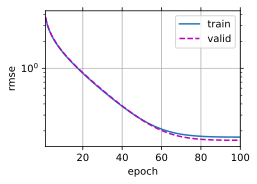

In [15]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.132288, valid log rmse 0.144080
fold 2, train log rmse 0.130236, valid log rmse 0.147959
fold 3, train log rmse 0.128926, valid log rmse 0.143099
fold 4, train log rmse 0.133826, valid log rmse 0.135300
fold 5, train log rmse 0.126091, valid log rmse 0.167571
5-折验证: 平均训练log rmse: 0.130274, 平均验证log rmse: 0.147602


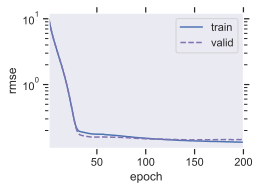

In [79]:
k, num_epochs, lr, weight_decay, batch_size = 6, 200, 0.001, 0.3, 64
num_hiddens1 = 150
num_hiddens2 = 32
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

选择隐层单元（200）

fold 1, train log rmse 0.135888, valid log rmse 0.144008
fold 2, train log rmse 0.134369, valid log rmse 0.148992
fold 3, train log rmse 0.133401, valid log rmse 0.142162
fold 4, train log rmse 0.137136, valid log rmse 0.137312
fold 5, train log rmse 0.131115, valid log rmse 0.170273
5-折验证: 平均训练log rmse: 0.134382, 平均验证log rmse: 0.148549


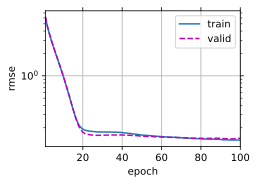

In [24]:
k, num_epochs, lr, weight_decay, batch_size, num_hiddens = 5, 100, 0.01, 0, 64, 200
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.145826, valid log rmse 0.146959
fold 2, train log rmse 0.141642, valid log rmse 0.156024
fold 3, train log rmse 0.141062, valid log rmse 0.146781
fold 4, train log rmse 0.145207, valid log rmse 0.144422
fold 5, train log rmse 0.138712, valid log rmse 0.172213
5-折验证: 平均训练log rmse: 0.142490, 平均验证log rmse: 0.153280


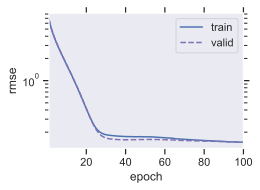

In [35]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 0, 64
num_hiddens = 100
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.140088, valid log rmse 0.144931
fold 2, train log rmse 0.137664, valid log rmse 0.151324
fold 3, train log rmse 0.135497, valid log rmse 0.143174
fold 4, train log rmse 0.140720, valid log rmse 0.141180
fold 5, train log rmse 0.134071, valid log rmse 0.171172
5-折验证: 平均训练log rmse: 0.137608, 平均验证log rmse: 0.150356


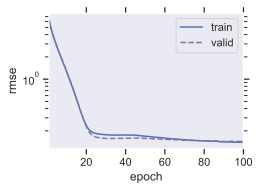

In [36]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 0, 64
num_hiddens = 150
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.159516, valid log rmse 0.154017
fold 2, train log rmse 0.153744, valid log rmse 0.177524
fold 3, train log rmse 0.152741, valid log rmse 0.156393
fold 4, train log rmse 0.157744, valid log rmse 0.152374
fold 5, train log rmse 0.152937, valid log rmse 0.178920
5-折验证: 平均训练log rmse: 0.155336, 平均验证log rmse: 0.163846


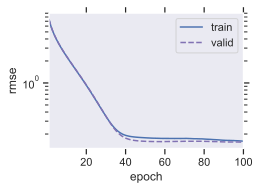

In [37]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 0, 64
num_hiddens = 50
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

选择k值（6）

fold 1, train log rmse 0.140844, valid log rmse 0.138412
fold 2, train log rmse 0.129850, valid log rmse 0.160480
fold 3, train log rmse 0.141699, valid log rmse 0.127839
fold 4, train log rmse 0.132990, valid log rmse 0.167400
4-折验证: 平均训练log rmse: 0.136346, 平均验证log rmse: 0.148533


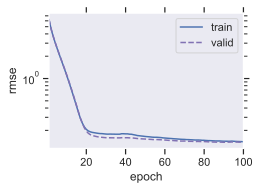

In [38]:
k, num_epochs, lr, weight_decay, batch_size = 4, 100, 0.01, 0, 64
num_hiddens = 200
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.143850, valid log rmse 0.145444
fold 2, train log rmse 0.135576, valid log rmse 0.148449
fold 3, train log rmse 0.135836, valid log rmse 0.163959
3-折验证: 平均训练log rmse: 0.138421, 平均验证log rmse: 0.152618


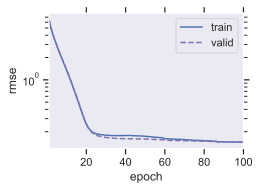

In [39]:
k, num_epochs, lr, weight_decay, batch_size = 3, 100, 0.01, 0, 64
num_hiddens = 200
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.135007, valid log rmse 0.146556
fold 2, train log rmse 0.138197, valid log rmse 0.132552
fold 3, train log rmse 0.128616, valid log rmse 0.164502
fold 4, train log rmse 0.137481, valid log rmse 0.124749
fold 5, train log rmse 0.136330, valid log rmse 0.150234
fold 6, train log rmse 0.133278, valid log rmse 0.168673
6-折验证: 平均训练log rmse: 0.134818, 平均验证log rmse: 0.147878


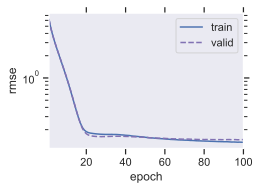

In [40]:
k, num_epochs, lr, weight_decay, batch_size = 6, 100, 0.01, 0, 64
num_hiddens = 200
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.134783, valid log rmse 0.148640
fold 2, train log rmse 0.136561, valid log rmse 0.131017
fold 3, train log rmse 0.132144, valid log rmse 0.150399
fold 4, train log rmse 0.130516, valid log rmse 0.151481
fold 5, train log rmse 0.138716, valid log rmse 0.119725
fold 6, train log rmse 0.134325, valid log rmse 0.157885
fold 7, train log rmse 0.132542, valid log rmse 0.172425
7-折验证: 平均训练log rmse: 0.134227, 平均验证log rmse: 0.147368


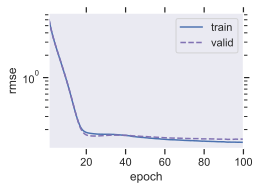

In [41]:
k, num_epochs, lr, weight_decay, batch_size = 7, 100, 0.01, 0, 64
num_hiddens = 200
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

选择num_epoch(150)

fold 1, train log rmse 0.157714, valid log rmse 0.157931
fold 2, train log rmse 0.159704, valid log rmse 0.147859
fold 3, train log rmse 0.148418, valid log rmse 0.201779
fold 4, train log rmse 0.158042, valid log rmse 0.131017
fold 5, train log rmse 0.153723, valid log rmse 0.160549
fold 6, train log rmse 0.158348, valid log rmse 0.178941
6-折验证: 平均训练log rmse: 0.155991, 平均验证log rmse: 0.163013


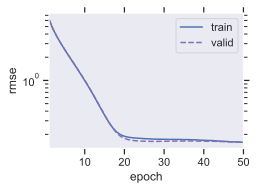

In [43]:
k, num_epochs, lr, weight_decay, batch_size = 6, 50, 0.01, 0, 64
num_hiddens = 200
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.127729, valid log rmse 0.148247
fold 2, train log rmse 0.130525, valid log rmse 0.133337
fold 3, train log rmse 0.121328, valid log rmse 0.161857
fold 4, train log rmse 0.129979, valid log rmse 0.126021
fold 5, train log rmse 0.130147, valid log rmse 0.149869
fold 6, train log rmse 0.125398, valid log rmse 0.165595
6-折验证: 平均训练log rmse: 0.127518, 平均验证log rmse: 0.147488


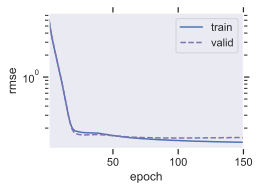

In [44]:
k, num_epochs, lr, weight_decay, batch_size = 6, 150, 0.01, 0, 64
num_hiddens = 200
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.125928, valid log rmse 0.155176
fold 2, train log rmse 0.127062, valid log rmse 0.140928
fold 3, train log rmse 0.118506, valid log rmse 0.163713
fold 4, train log rmse 0.127176, valid log rmse 0.130249
fold 5, train log rmse 0.127813, valid log rmse 0.150727
fold 6, train log rmse 0.122209, valid log rmse 0.164514
6-折验证: 平均训练log rmse: 0.124782, 平均验证log rmse: 0.150884


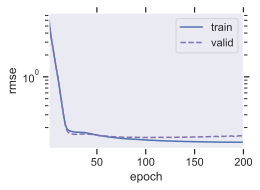

In [45]:
k, num_epochs, lr, weight_decay, batch_size = 6, 200, 0.01, 0, 64
num_hiddens = 200
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

选择lr(0.01)

fold 1, train log rmse 0.125291, valid log rmse 0.180594
fold 2, train log rmse 0.125407, valid log rmse 0.174992
fold 3, train log rmse 0.115566, valid log rmse 0.171770
fold 4, train log rmse 0.127053, valid log rmse 0.145175
fold 5, train log rmse 0.126285, valid log rmse 0.160545
fold 6, train log rmse 0.117463, valid log rmse 0.164661
6-折验证: 平均训练log rmse: 0.122844, 平均验证log rmse: 0.166289


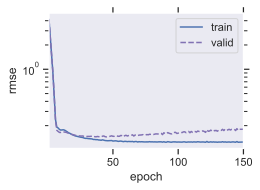

In [47]:
k, num_epochs, lr, weight_decay, batch_size = 6, 150, 0.03, 0, 64
num_hiddens = 200
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.160296, valid log rmse 0.158783
fold 2, train log rmse 0.161928, valid log rmse 0.149036
fold 3, train log rmse 0.150172, valid log rmse 0.204536
fold 4, train log rmse 0.160202, valid log rmse 0.132588
fold 5, train log rmse 0.155821, valid log rmse 0.161097
fold 6, train log rmse 0.160648, valid log rmse 0.180094
6-折验证: 平均训练log rmse: 0.158178, 平均验证log rmse: 0.164356


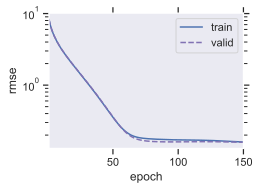

In [49]:
k, num_epochs, lr, weight_decay, batch_size = 6, 150, 0.003, 0, 64
num_hiddens = 200
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.422537, valid log rmse 0.427678
fold 2, train log rmse 0.422383, valid log rmse 0.434665
fold 3, train log rmse 0.421027, valid log rmse 0.442530
fold 4, train log rmse 0.424119, valid log rmse 0.415109
fold 5, train log rmse 0.423451, valid log rmse 0.417258
fold 6, train log rmse 0.423354, valid log rmse 0.416228
6-折验证: 平均训练log rmse: 0.422812, 平均验证log rmse: 0.425578


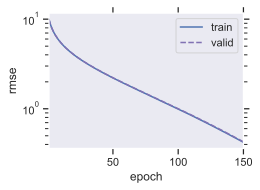

In [50]:
k, num_epochs, lr, weight_decay, batch_size = 6, 150, 0.001, 0, 64
num_hiddens = 200
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

 weight_decay(0.3)

fold 1, train log rmse 0.127682, valid log rmse 0.148194
fold 2, train log rmse 0.130872, valid log rmse 0.133648
fold 3, train log rmse 0.121598, valid log rmse 0.162185
fold 4, train log rmse 0.130068, valid log rmse 0.125987
fold 5, train log rmse 0.130246, valid log rmse 0.149463
fold 6, train log rmse 0.125728, valid log rmse 0.165362
6-折验证: 平均训练log rmse: 0.127699, 平均验证log rmse: 0.147473


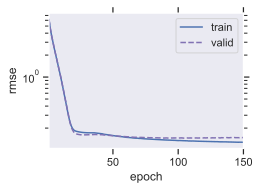

In [51]:
k, num_epochs, lr, weight_decay, batch_size = 6, 150, 0.01, 0.5, 64
num_hiddens = 200
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.127622, valid log rmse 0.148083
fold 2, train log rmse 0.130596, valid log rmse 0.133342
fold 3, train log rmse 0.121525, valid log rmse 0.162104
fold 4, train log rmse 0.130240, valid log rmse 0.125902
fold 5, train log rmse 0.130128, valid log rmse 0.149202
fold 6, train log rmse 0.125694, valid log rmse 0.165410
6-折验证: 平均训练log rmse: 0.127634, 平均验证log rmse: 0.147341


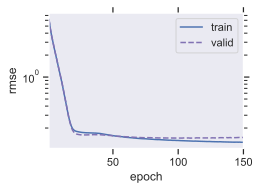

In [52]:
k, num_epochs, lr, weight_decay, batch_size = 6, 150, 0.01, 0.3, 64
num_hiddens = 200
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.127732, valid log rmse 0.147768
fold 2, train log rmse 0.130734, valid log rmse 0.133384
fold 3, train log rmse 0.121540, valid log rmse 0.162065
fold 4, train log rmse 0.130368, valid log rmse 0.125924
fold 5, train log rmse 0.130196, valid log rmse 0.150186
fold 6, train log rmse 0.125457, valid log rmse 0.165032
6-折验证: 平均训练log rmse: 0.127671, 平均验证log rmse: 0.147393


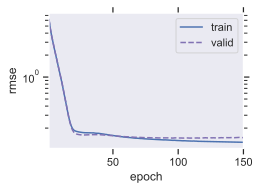

In [53]:
k, num_epochs, lr, weight_decay, batch_size = 6, 150, 0.01, 0.7, 64
num_hiddens = 200
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.127587, valid log rmse 0.148139
fold 2, train log rmse 0.130294, valid log rmse 0.132686
fold 3, train log rmse 0.121574, valid log rmse 0.162247
fold 4, train log rmse 0.130301, valid log rmse 0.125984
fold 5, train log rmse 0.129842, valid log rmse 0.149157
fold 6, train log rmse 0.125901, valid log rmse 0.166106
6-折验证: 平均训练log rmse: 0.127583, 平均验证log rmse: 0.147387


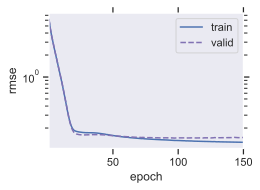

In [54]:
k, num_epochs, lr, weight_decay, batch_size = 6, 150, 0.01, 0.1, 64
num_hiddens = 200
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.127666, valid log rmse 0.148375
fold 2, train log rmse 0.130710, valid log rmse 0.133350
fold 3, train log rmse 0.121277, valid log rmse 0.162088
fold 4, train log rmse 0.130356, valid log rmse 0.126053
fold 5, train log rmse 0.130076, valid log rmse 0.149885
fold 6, train log rmse 0.125484, valid log rmse 0.165668
6-折验证: 平均训练log rmse: 0.127595, 平均验证log rmse: 0.147570


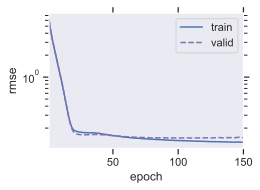

In [55]:
k, num_epochs, lr, weight_decay, batch_size = 6, 150, 0.01, 0.9, 64
num_hiddens = 200
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

batch_size

fold 1, train log rmse 0.161727, valid log rmse 0.163872
fold 2, train log rmse 0.163021, valid log rmse 0.155088
fold 3, train log rmse 0.152864, valid log rmse 0.203280
fold 4, train log rmse 0.161558, valid log rmse 0.135028
fold 5, train log rmse 0.157988, valid log rmse 0.164794
fold 6, train log rmse 0.161915, valid log rmse 0.182023
6-折验证: 平均训练log rmse: 0.159845, 平均验证log rmse: 0.167347


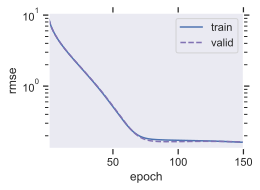

In [57]:
k, num_epochs, lr, weight_decay, batch_size = 6, 150, 0.01, 0.3, 256
num_hiddens = 200
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.124865, valid log rmse 0.158266
fold 2, train log rmse 0.125634, valid log rmse 0.147486
fold 3, train log rmse 0.117219, valid log rmse 0.165721
fold 4, train log rmse 0.126378, valid log rmse 0.134193
fold 5, train log rmse 0.126980, valid log rmse 0.153610
fold 6, train log rmse 0.119827, valid log rmse 0.163699
6-折验证: 平均训练log rmse: 0.123484, 平均验证log rmse: 0.153829


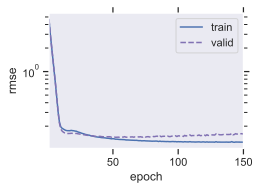

In [58]:
k, num_epochs, lr, weight_decay, batch_size = 6, 150, 0.01, 0.3, 32
num_hiddens = 200
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

# 预测

In [80]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission1.csv', index=False)

train log rmse 0.128851


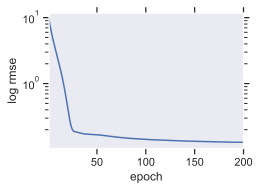

In [81]:
k, num_epochs, lr, weight_decay, batch_size = 6, 200, 0.001, 0.3, 64
num_hiddens1 = 150
num_hiddens2 = 32
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)